# Case Study

## Initial data analysis and preprocessing

In [1]:
# just tweets mentioning Dell during first three quarters of 2022 
# https://www.kaggle.com/datasets/ankitkumar2635/dell-tweets-2022
import pandas as pd

df_dell = pd.read_csv("./analysis_data/First three qtr Dell tweets.csv")
df_dell.dropna(inplace=True)
df_dell.drop_duplicates(inplace=True)
df_dell.head()

,Datetime,Tweet Id,Text,Username
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella


In [2]:
len(df_dell)

24970

In [3]:
import pandas as pd
import re
from collections import Counter

# counting most frequent mentions
df_dell["mentions"] = df_dell["Text"].apply(lambda x: re.findall(r'@\S+', str(x)) if pd.notna(x) else [])
all_mentions = [mention for mentions in df_dell["mentions"] for mention in mentions]
mention_counts = pd.Series(Counter(all_mentions))
mention_counts = mention_counts.sort_values(ascending=False)
for index, value in mention_counts[:100].items():
    print(f"{index}: {value}")

@Dell: 22990
@DellCares: 2493
@MichaelDell: 2077
@dell: 1257
@elonmusk: 1111
@Twitter: 1096
@emc: 1017
@Alienware: 994
@HP: 936
@Microsoft: 834
@DellTech: 715
@Dell_IN: 704
@Apple: 594
@intel: 561
@Dell,: 537
@Lenovo: 504
@DellOutlet: 396
@AlokOhrie: 369
@starwars: 342
@ScienceNews: 337
@TheRock: 337
@WWEUniverse: 337
@JohnCena: 336
@StarTrek: 336
@steveaustinBSR: 336
@CountryMusic: 336
@_KennyRogers: 335
@playstation: 333
@AmericanAir: 315
@Dell.: 314
@Oracle: 296
@intelcanada: 277
@DellCaresPRO: 276
@JuddLegum: 271
@DellTechIndia: 265
@Windows: 261
@NRCC: 239
@Google: 237
@ATT: 233
@NRSC: 182
@jagograhakjago: 179
@SecretGamerGrrl: 172
@straczynski: 169
@AnsgarTOdinson: 163
@mikecodemonkey: 162
@ASUS: 158
@RapSnacksNow: 154
@Zipchair: 154
@ZipchairGaming: 153
@ubuntu: 150
@GamersNexus: 147
@Acer: 142
@Dell's: 142
@DellServices: 138
@SouthwestAir: 138
@BNCNews: 136
@amazon: 134
@WholeFoods: 128
@HPE: 127
@BNCGO: 127
@IBM: 126
@Cisco: 125
@HEB: 117
@Deloitte: 116
@DellTechMEA: 115
@Leno

In [4]:
# replacing urls and user mentions while keeping select mentions
import re
from urlextract import URLExtract

mentions_to_keep = ["Dell", "Delltech", "Dellcares", "Dell,", "DellOutlet", "Dell_IN", "DellCaresPRO", "DellTechIndia",
                    "Dell's", "DellServices", "dellindia", "DellUK", "DellTechZA", "FedEx", "HPIndia", "PwC", "Delta",
                    "Deloitte", "AlienwareTech", "AMD", "Acer", "Tesla", "comcast", "Meta", "nvidia", "Ford", "YouTube",
                    "HP", "Microsoft", "Apple", "Logitech", "ubuntu", "playstation", "Windows", "Oracle", "intelcanada",
                    "Google", "ASUS", "Lenovo", "Tesla", "Intel", "Alienware", "Emc", "WWEUniverse", "AmericanAir",
                    "Zipchair", "ZipchairGaming", "RapSnacksNow", "ATT", "IBM", "amazon", "Walmart", "Cisco", 
                    "MichaelDell", "AlokOhrie", "Elonmusk", "JohnCena", "TheRock", "steveaustinBSR", "_KennyRogers",
                    "VMware", "SouthwestAir", "Lenovo_in"]

extractor = URLExtract()

def format_tweet_new_keep(tweet):

    tokens = tweet.split()
    tokens = [token[1:].capitalize() if token.startswith("@") and token[1:].capitalize() in mentions_to_keep else token for token in tokens]

    tweet = " ".join(tokens)

    urls = extractor.find_urls(tweet)
    for url in urls:
        tweet = tweet.replace(url, "{{URL}}")

    tweet = re.sub(r'@\S+', "{{MENTION}}", tweet)

    return tweet

df_dell["text"] = df_dell.apply(lambda x: format_tweet_new_keep(str(x["Text"])), axis=1)
df_dell.head()

,Datetime,Tweet Id,Text,Username,mentions,text
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,"[@Logitech, @apple, @Google, @Microsoft, @Dell...",Logitech Apple Google Microsoft Dell Lenovo #W...
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,"[@MK_habit_addict, @official_stier, @MortalKom...",{{MENTION}} {{MENTION}} {{MENTION}} {{MENTION}...
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,"[@CRN, @stevenjburke, @Cisco, @Microsoft, @HPE...",As {{MENTION}} celebrates its 40th anniversary...
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,"[@dell, @DellTech]",Dell your customer service is horrible especia...
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,"[@zacokalo, @Dell, @DellCares, @Dell]",{{MENTION}} Dell Dellcares Dell give the man w...


In [5]:
df_dell["tokens"] = df_dell["text"].apply(lambda x: x.split())
df_dell["tokens"].str.len().agg(["mean","max","std"])

mean     26.744854
max     100.000000
std      14.586818
Name: tokens, dtype: float64

In [6]:
df_dell = df_dell[["Datetime", "text", "tokens"]]
df_dell.head()

,Datetime,text,tokens
0,2022-09-30 23:29:15+00:00,Logitech Apple Google Microsoft Dell Lenovo #W...,"[Logitech, Apple, Google, Microsoft, Dell, Len..."
1,2022-09-30 21:46:35+00:00,{{MENTION}} {{MENTION}} {{MENTION}} {{MENTION}...,"[{{MENTION}}, {{MENTION}}, {{MENTION}}, {{MENT..."
2,2022-09-30 21:18:02+00:00,As {{MENTION}} celebrates its 40th anniversary...,"[As, {{MENTION}}, celebrates, its, 40th, anniv..."
3,2022-09-30 20:05:24+00:00,Dell your customer service is horrible especia...,"[Dell, your, customer, service, is, horrible, ..."
4,2022-09-30 20:03:17+00:00,{{MENTION}} Dell Dellcares Dell give the man w...,"[{{MENTION}}, Dell, Dellcares, Dell, give, the..."


In [7]:
len(df_dell)

24970

In [8]:
df_dell.to_json("./analysis_data/dell_cs_processed.json", orient="records")

Predicting entity- and sentiment-labels is performed in the respective notebooks

## processing the predictions

In [9]:
df_dell_p = pd.read_json("./analysis_data/dell_cs_after_predictions.json", orient="records")
df_dell_p["sentiment_labels"] = df_dell_p["bert_pred_sa"].replace({0 : "negative", 1 : "neutral", 2 : "positive"})
df_dell_p["Datetime"] = pd.to_datetime(df_dell_p["Datetime"])
df_dell_p.head()

,Datetime,text,tokens,covid_bert_pred,bert_pred_sa,sentiment_labels
0,2022-09-30 23:29:15,Logitech Apple Google Microsoft Dell Lenovo #W...,"[Logitech, Apple, Google, Microsoft, Dell, Len...","[0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10,...",2,positive
1,2022-09-30 21:46:35,{{MENTION}} {{MENTION}} {{MENTION}} {{MENTION}...,"[{{MENTION}}, {{MENTION}}, {{MENTION}}, {{MENT...","[10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10...",1,neutral
2,2022-09-30 21:18:02,As {{MENTION}} celebrates its 40th anniversary...,"[As, {{MENTION}}, celebrates, its, 40th, anniv...","[10, 0, 10, 10, 10, 10, 3, 8, 10, 3, 10, 10, 1...",2,positive
3,2022-09-30 20:05:24,Dell your customer service is horrible especia...,"[Dell, your, customer, service, is, horrible, ...","[0, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10,...",0,negative
4,2022-09-30 20:03:17,{{MENTION}} Dell Dellcares Dell give the man w...,"[{{MENTION}}, Dell, Dellcares, Dell, give, the...","[10, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10]",0,negative


In [10]:
sum(df_dell_p["tokens"].str.len() != df_dell_p["covid_bert_pred"].str.len())

53

In [11]:
# removing the rows with mismatched lengths (caused by truncation to max length of 128 tokens)
df_dell_p = df_dell_p[df_dell_p["tokens"].str.len() == df_dell_p["covid_bert_pred"].str.len()]
print(f"Number of rows predicted in their entirety: {len(df_dell_p)}")

Number of rows predicted in their entirety: 24917


In [12]:
df_dell_p[df_dell_p["bert_pred_sa"].isin([0, 1, 2])].shape[0]

24917

In [13]:
print(df_dell_p["sentiment_labels"].value_counts())

sentiment_labels
negative    11309
positive     8530
neutral      5078
Name: count, dtype: int64


In [14]:
# converting the tags of recognized instances of Dell mentions from tag-column to 10 ("O"-tag)
own_company_names = ["Dell", "Delltech", "Dellcares", "Dell,", "DellOutlet", "Dell_IN", "DellCaresPRO", "DellTechIndia",
                    "Dell's", "DellServices", "dellindia", "DellUK", "DellTechZA"]

for index, row in df_dell_p.iterrows():
    tokens = row["tokens"]
    labels = row["covid_bert_pred"]
    for i in range(len(tokens)):
        if tokens[i] in own_company_names and labels[i] != 10:
            labels[i] = 10
            modified = True
    
    if modified:
        df_dell_p.at[index, "covid_bert_pred"] = labels

In [15]:
entity_dict = {
    0: "B-corporation",
    1: "B-event",
    2: "B-location",
    3: "B-person",
    4: "B-product",
    5: "I-corporation",
    6: "I-event",
    7: "I-location",
    8: "I-person",
    9: "I-product",
    10: "O"
}

label_list = list(entity_dict.values())
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

df_dell_p["ner_labels"] = df_dell_p["covid_bert_pred"].apply(lambda x: [id_to_label[i] for i in x])

In [16]:
def get_types_from_list(lst):
    r = []
    for entry in lst:
        if entry != "O":
            parts = entry.split("-", 1)
            if len(parts) > 1:
                entity_type = parts[1]
                if entity_type not in r:
                    r.append(entity_type)
    return r

df_dell_p["entity_types"] = df_dell_p["ner_labels"].apply(get_types_from_list)
df_dell_p.head()

,Datetime,text,tokens,covid_bert_pred,bert_pred_sa,sentiment_labels,ner_labels,entity_types
0,2022-09-30 23:29:15,Logitech Apple Google Microsoft Dell Lenovo #W...,"[Logitech, Apple, Google, Microsoft, Dell, Len...","[0, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10...",2,positive,"[B-corporation, B-corporation, B-corporation, ...",[corporation]
1,2022-09-30 21:46:35,{{MENTION}} {{MENTION}} {{MENTION}} {{MENTION}...,"[{{MENTION}}, {{MENTION}}, {{MENTION}}, {{MENT...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1,neutral,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
2,2022-09-30 21:18:02,As {{MENTION}} celebrates its 40th anniversary...,"[As, {{MENTION}}, celebrates, its, 40th, anniv...","[10, 0, 10, 10, 10, 10, 3, 8, 10, 3, 10, 10, 1...",2,positive,"[O, B-corporation, O, O, O, O, B-person, I-per...","[corporation, person]"
3,2022-09-30 20:05:24,Dell your customer service is horrible especia...,"[Dell, your, customer, service, is, horrible, ...","[10, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10...",0,negative,"[O, O, O, O, O, O, O, O, B-person, O, O, O, O,...","[person, product]"
4,2022-09-30 20:03:17,{{MENTION}} Dell Dellcares Dell give the man w...,"[{{MENTION}}, Dell, Dellcares, Dell, give, the...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]",0,negative,"[O, O, O, O, O, O, O, O, O, O, O]",[]


In [17]:
df_dell_p["entity_types"].explode().value_counts()

entity_types
corporation    9854
product        9647
person         3802
location       1406
event           556
Name: count, dtype: int64

## visual explorations

In [18]:
df_dell_p.head()

,Datetime,text,tokens,covid_bert_pred,bert_pred_sa,sentiment_labels,ner_labels,entity_types
0,2022-09-30 23:29:15,Logitech Apple Google Microsoft Dell Lenovo #W...,"[Logitech, Apple, Google, Microsoft, Dell, Len...","[0, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10...",2,positive,"[B-corporation, B-corporation, B-corporation, ...",[corporation]
1,2022-09-30 21:46:35,{{MENTION}} {{MENTION}} {{MENTION}} {{MENTION}...,"[{{MENTION}}, {{MENTION}}, {{MENTION}}, {{MENT...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",1,neutral,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
2,2022-09-30 21:18:02,As {{MENTION}} celebrates its 40th anniversary...,"[As, {{MENTION}}, celebrates, its, 40th, anniv...","[10, 0, 10, 10, 10, 10, 3, 8, 10, 3, 10, 10, 1...",2,positive,"[O, B-corporation, O, O, O, O, B-person, I-per...","[corporation, person]"
3,2022-09-30 20:05:24,Dell your customer service is horrible especia...,"[Dell, your, customer, service, is, horrible, ...","[10, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10...",0,negative,"[O, O, O, O, O, O, O, O, B-person, O, O, O, O,...","[person, product]"
4,2022-09-30 20:03:17,{{MENTION}} Dell Dellcares Dell give the man w...,"[{{MENTION}}, Dell, Dellcares, Dell, give, the...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]",0,negative,"[O, O, O, O, O, O, O, O, O, O, O]",[]


### bar chart

{'corporation': 0.39547297026126743, 'product': 0.3871653890917847, 'person': 0.15258658747040174, 'location': 0.0564273387646988, 'event': 0.022314082754745754}


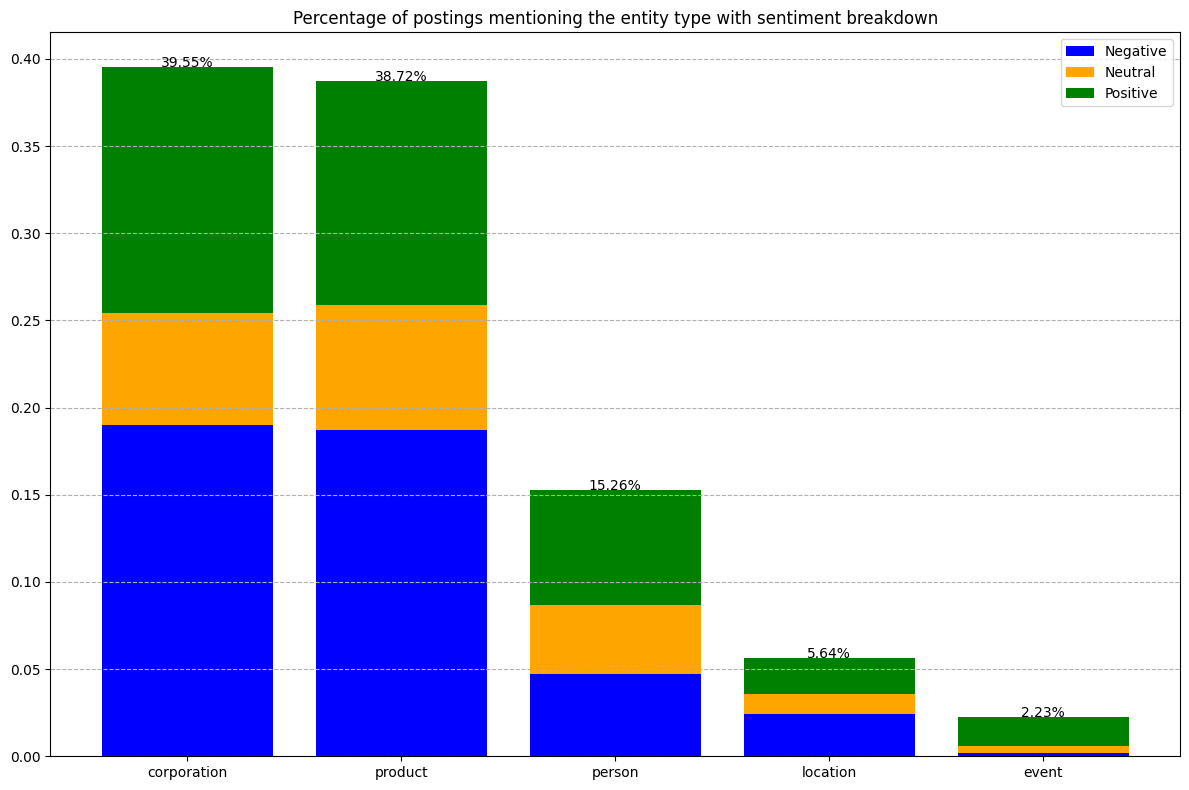

In [19]:
import matplotlib.pyplot as plt

unique_entities = ["corporation", "product", "person", "location", "event"]

def mentioned_entities_with_sentiment_breakdown(df_results):
    dic = {}
    for entity_type in unique_entities:
        df_results["entity_mentioned"] = df_results["entity_types"].apply(lambda x: entity_type in x)
        filtered_df = df_results[df_results["entity_mentioned"]==True]
        percentage = len(filtered_df)/len(df_results)
        dic[entity_type] = percentage

    print(dic)

    entity_dic = {}
    for entity_type in unique_entities:
        df_results["entity_mentioned"] = df_results["entity_types"].apply(lambda x: entity_type in x)
        filtered_df = df_results[df_results["entity_mentioned"]==True]
        percentage = len(filtered_df)/len(df_results)
        entity_dic[entity_type] = percentage

    sentiment_dic = {}
    for entity_type in unique_entities:
        df_results["entity_mentioned"] = df_results["entity_types"].apply(lambda x: entity_type in x)
        filtered_df = df_results[df_results["entity_mentioned"]==True]
        sentiment_dic[entity_type] = {"negative": 0, "neutral": 0, "positive": 0}

        total_count = len(filtered_df)
        negative_count = len(filtered_df[filtered_df["sentiment_labels"] == "negative"])
        neutral_count = len(filtered_df[filtered_df["sentiment_labels"] == "neutral"])
        positive_count = len(filtered_df[filtered_df["sentiment_labels"] == "positive"])
        
        sentiment_dic[entity_type] = {
            "negative": (negative_count / total_count) * dic[entity_type],
            "neutral": (neutral_count / total_count) * dic[entity_type],
            "positive": (positive_count / total_count) * dic[entity_type]
        }
        
    entity_types = list(entity_dic.keys())
    x = range(len(entity_types))
    total_percentages = list(entity_dic.values())

    negative_values = [sentiment_dic[entity]["negative"] for entity in entity_types]
    neutral_values = [sentiment_dic[entity]["neutral"] for entity in entity_types]
    positive_values = [sentiment_dic[entity]["positive"] for entity in entity_types]

    fig, ax = plt.subplots(figsize=(12, 8))

    p1 = ax.bar(x, negative_values, align="center", label="Negative", color="blue")
    p2 = ax.bar(x, neutral_values, align="center", bottom=negative_values, label="Neutral", color="orange")
    p3 = ax.bar(x, positive_values, align="center", 
                bottom=[p+n for p, n in zip(negative_values, neutral_values)], 
                label="Positive", color="green")

    for i, percentage in enumerate(total_percentages):
        v = f"{round(percentage*100, 2)}%"
        ax.text(i, percentage, v, ha="center")

    ax.set_xticks(x)
    ax.set_xticklabels(entity_types)
    ax.set_title("Percentage of postings mentioning the entity type with sentiment breakdown")
    ax.legend()
    ax.grid(axis="y", linestyle="--")

    plt.tight_layout()
    plt.show()

mentioned_entities_with_sentiment_breakdown(df_dell_p)

conclusions: 
- corporations and products are mentioned the most, in over 35% of all posts
- of corporation- and product-posts, negativity is the most common sentiment
- the large majority of posts contain sentiment, neutrality is quite rare

### word clouds

In [20]:
# creating wordclouds to investigate the vocabulary of negative corporation- and product posts
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

#adding frequently mentioned uninteresting words to the stopwords to not be included in the wordcloud
stopwords.update(["mention", "rt", "link", "url", "quot", "dell", "dellcares", "dellcare", "delltech"])

def create_wordcloud(df, entity, sentiment, text_col="text"):
    words = ""

    df["entity_mentioned"] = df["entity_types"].apply(lambda x: entity in x)
    filtered_df = df[(df["sentiment_labels"]==sentiment) & (df["entity_mentioned"]==True)]

    for val in filtered_df[text_col]:
        val = str(val)
        tokens = val.split()
        
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width=800, 
                          height=800,
                        background_color="white",
                        stopwords=stopwords,
                        min_font_size=10).generate(words)
                    
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.title(f"Wordcloud of all {sentiment} postings mentioning a {entity}")
    plt.show()

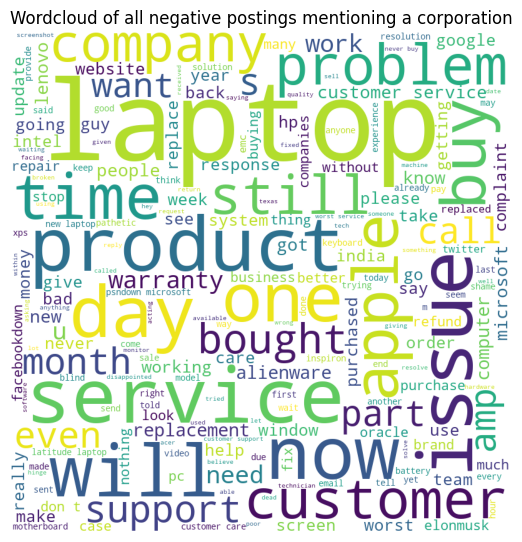

In [21]:
create_wordcloud(df_dell_p, "corporation", "negative")

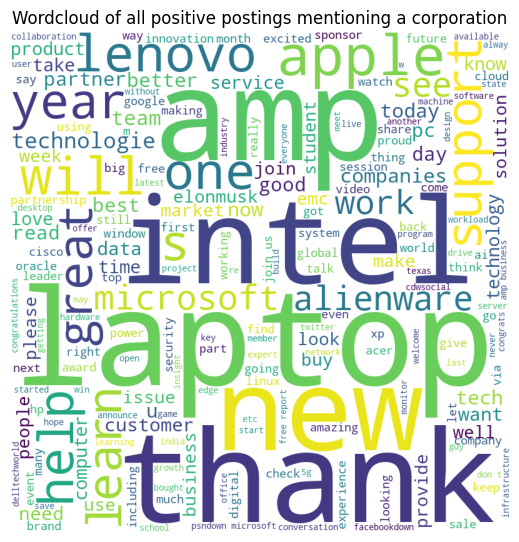

In [22]:
create_wordcloud(df_dell_p, "corporation", "positive")

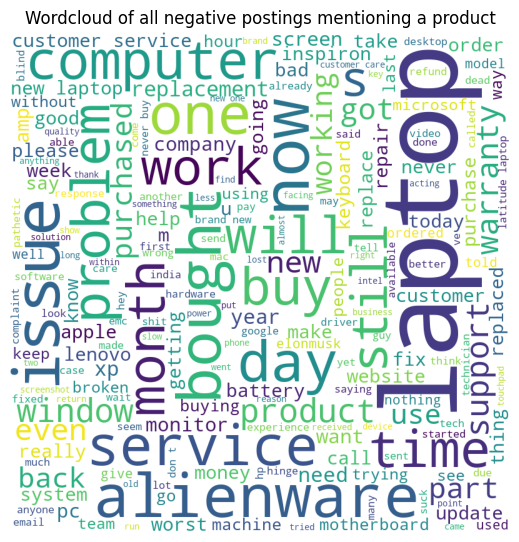

In [23]:
create_wordcloud(df_dell_p, "product", "negative")

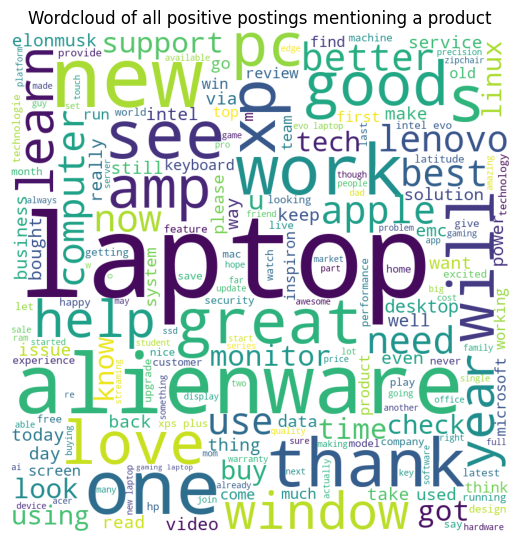

In [24]:
create_wordcloud(df_dell_p, "product", "positive")

conclusions:
- corporation: general problems related to technology, sometimes related to competitors
- product: warranty often related, apparently mostly general issues with products

### entity type pair sentiment heatmap

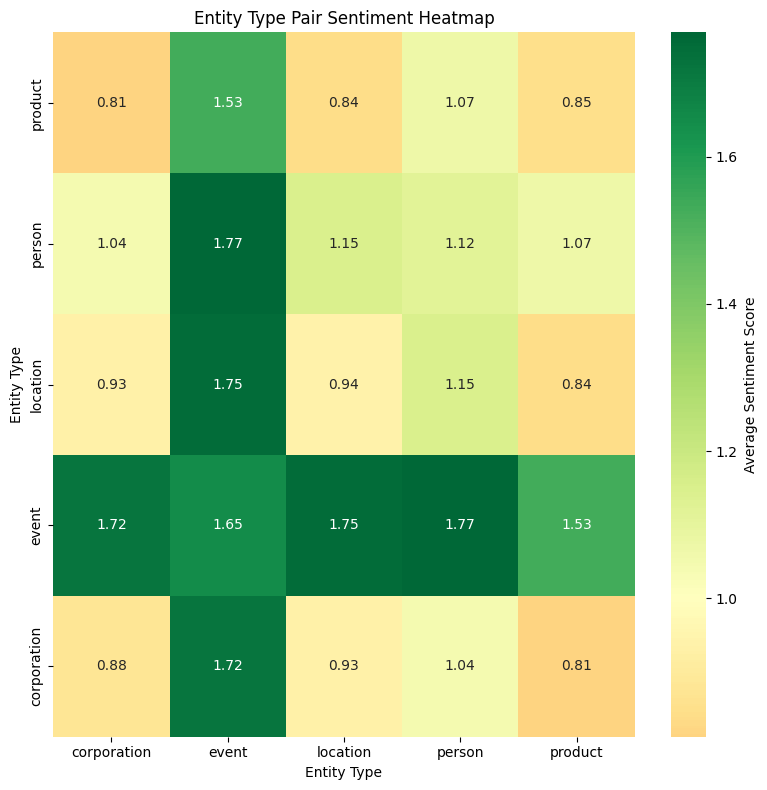

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_entity_types = sorted(set([entity for sublist in df_dell_p['entity_types'] for entity in sublist]))

sentiment_matrix = pd.DataFrame(
    index=all_entity_types,
    columns=all_entity_types,
    dtype=float
)

for i, type1 in enumerate(all_entity_types):
    for j, type2 in enumerate(all_entity_types):
        if i <= j:
            mask = df_dell_p['entity_types'].apply(lambda x: type1 in x and type2 in x)
            if mask.sum() > 0:
                avg_sentiment = df_dell_p.loc[mask, 'bert_pred_sa'].mean()
                sentiment_matrix.loc[type1, type2] = avg_sentiment
                if i != j:  
                    sentiment_matrix.loc[type2, type1] = avg_sentiment

# adjusting the order of the y-axis
sentiment_matrix_aligned = sentiment_matrix.iloc[::-1]

plt.figure(figsize=(8, 8))
sns.heatmap(
    sentiment_matrix_aligned,  
    annot=True,
    fmt=".2f",
    cmap=plt.cm.RdYlGn,
    center=1,
    cbar_kws={'label': 'Average Sentiment Score'}
)
plt.title("Entity Type Pair Sentiment Heatmap")
plt.xlabel("Entity Type")
plt.ylabel("Entity Type")

plt.tight_layout()
plt.show()

conclusions:
- events mentioned in positive discussions regardless of other entities present
- location-person the next strongest pairing, persons in general also quite positive
- product-corporation is the most negatively associated pairing

### top 10 instances with sentiment

In [26]:
# getting instance based insight to investigate most frequently mentioned instances of entities
import regex as re

instances_to_remove = own_company_names + ["Mention", "Url", "Computer", "Laptop", "Laptops", "Pc", "Monitor", "2022"]

entity_mapping = {
    "person": {
        "Elon": "Elon Musk",
        "Elonmusk": "Elon Musk",
        "Elon musk": "Elon Musk"
    },
    "location": {
        "Tx" : "Texas",
        "Us" : "Usa"
    },
    "event": {
        "Ces" : "Ces 2022",
        "New year" : "New years" 
    },
    "corporation": {
         "HPIndia" : "HP",
         "Lenovo_in" : "Lenovo",
         "intelcanada" : "Intel"
    }
#         "Dell computers": "Dell",
#         "Dell tech": "Dell Technologies",
#         "Dell technology": "Dell Technologies",
#     },
#     "product": {
#         "Xps13": "XPS 13",
#         "Xps 13plus": "XPS 13 Plus",
#         "Alienware": "Alienware laptop",
#     }
}

def get_instance_dic(df):
    unique_entities = ["corporation", "product", "person", "location", "event"]
    instance_dic = {}
    
    for type in unique_entities:
        type_list = []
        
        for index, row in df.iterrows():
            tokens = row["tokens"]
            labels = row["ner_labels"]
            
            i = 0
            while i < len(labels):
                if labels[i] == f"B-{type}":
                    entity_tokens = [tokens[i]]
                    j = i + 1
                    
                    while j < len(labels) and labels[j] == f"I-{type}":
                        entity_tokens.append(tokens[j])
                        j += 1
                    
                    complete_entity = " ".join(entity_tokens)
                    complete_entity = re.sub(r'[^a-zA-Z0-9\s]', '', complete_entity).capitalize().strip().removesuffix("'s")
                    
                    # applying manual mapping to group select instances together
                    if type in entity_mapping and complete_entity in entity_mapping[type]:
                        complete_entity = entity_mapping[type][complete_entity]
                    
                    if complete_entity not in instances_to_remove:
                        type_list.append(complete_entity)
                    
                    i = j
                else:
                    i += 1
        
        instance_dic[type] = type_list
    
     # remove trailing "s" if instance is already known with 2nd pass through instance_dic to replace "Googles" with "Google"
    for type in instance_dic:
        unique_instances = set(instance_dic[type])  
        new_type_list = []

        for entity in instance_dic[type]:
            if entity.endswith("s"):
                singular_candidate = entity[:-1]  
                if singular_candidate in unique_instances:
                    entity = singular_candidate 
            
            new_type_list.append(entity)

        instance_dic[type] = new_type_list

    return instance_dic

instance_dic = get_instance_dic(df_dell_p)
print(instance_dic["product"])
    
for key in instance_dic.keys():
    print(f"Detected instances of {key}: {len(instance_dic[key])}")

['Alienware', 'Intel', 'Alienware', 'Alienware', 'Apo 13 equalizer', 'Alienware', 'Alienware', 'Intel core i5 1135g7', 'Intel core i5 1235', 'Cinebench r23', 'Dell laptop', 'Dell monitor', 'Xps 15 9520', 'Mobo', 'Clonezilla', 'Chrome', 'Firefox', 'Amd', 'Threadripper 5000 processors', 'Telco cloud', 'Wireless', 'Acer alienware lenovo', 'Aluminum', 'Xps 15 9570 model', 'Windows 10', 'Inspiron 14 7420 2in1 touchscreen laptop', 'Inspiron 14 7420 2in1 touchscreen laptop', 'Dell laptop', 'Private cloud', 'Xps 13 2in1', '7320s', 'Powermax', 'Headset', 'Xps 13 2in1', 'Dell 2', 'Xps 13 2in1', 'Xps 13 2in1', '1u rack server', 'Printer', 'Printer', 'Tablet', 'Laptopwhy', 'Anker dock', 'Lenovo', 'Thinkpad3', 'Alienware', 'Gem', 'Microsoft surface', 'Surface', 'Mac', 'Powermax', 'Lenovoin', 'Lenovo', 'Dell laptop', 'Openshift', 'Augmented reality', 'Private cloud', 'Dell g3 3579', 'Linux', 'Linux', 'Windows', 'Alienware', 'Qdoled ultrawide gaming monitor', 'Inspirion', 'Xps', 'Hdd', '32inch oled 4

In [27]:
def get_top_instances(instance_dic, top_n=10):
    top_instances = {}
    
    for entity_type, instances in instance_dic.items():
        instance_counts = {}
        for instance in instances:
            instance_counts[instance] = instance_counts.get(instance, 0) + 1
        
        sorted_instances = sorted(instance_counts.items(), key=lambda x: x[1], reverse=True)
        
        top_n_instances = sorted_instances[:top_n]
        
        top_instances[entity_type] = top_n_instances

    return top_instances

top_10_instances = get_top_instances(instance_dic, top_n=10)
for key in top_10_instances.keys():
    print(f"{key}: {top_10_instances[key]}")

corporation: [('Microsoft', 785), ('Apple', 631), ('Lenovo', 428), ('Intel', 398), ('Alienware', 285), ('Google', 227), ('Twitter', 173), ('Oracle', 159), ('Hp', 127), ('Acer', 87)]
product: [('Alienware', 370), ('Windows', 262), ('Dell laptop', 144), ('Mac', 126), ('Linux', 111), ('Macbook', 84), ('Lenovo', 81), ('Xps', 80), ('Windows 11', 72), ('Xps 13', 54)]
person: [('Elon Musk', 906), ('Michael', 57), ('Kenny roger', 34), ('Flokimon', 32), ('Gray', 20), ('Trump', 19), ('John lochausen', 15), ('Abbott', 15), ('Cody taylor', 13), ('Shelly', 11)]
location: [('India', 258), ('Texas', 193), ('Usa', 123), ('Russia', 70), ('China', 54), ('Uk', 31), ('Ukraine', 27), ('Canada', 25), ('Austin', 24), ('Spain', 23)]
event: [('Cdw executive summit', 33), ('Ces 2022', 12), ('Christmas', 11), ('New years', 8), ('3dexperience world', 8), ('Presidents day', 6), ('Smarter services executive symposium', 5), ('Labor day', 5), ('Startup awards national series', 5), ('Dare academy 2022', 4)]


In [28]:
# adding sentiment to the entity-instances, not including instances that could not be found in the text-column
def add_sentiment_to_instances(entity_dict, df):
    result = {}
    
    for entity_type, instances in entity_dict.items():
        instances_with_sentiment = []
        instances_not_found = []
        
        for entity, count in instances:
            entity_lower = entity.lower()
            
            # filtering in text-column to detect multi-token instances
            mask = df["text"].apply(lambda x: entity_lower in x.lower())
            
            if mask.sum() > 0:
                avg_sentiment = df.loc[mask, "bert_pred_sa"].mean()
                instances_with_sentiment.append((entity, count, avg_sentiment))
            else:
                instances_not_found.append(entity)
        
        if instances_not_found:
            print(f"{len(instances_not_found)} {entity_type} entities not found in text: {instances_not_found}")
            
        result[entity_type] = instances_with_sentiment
    
    return result

top_10_instances2 = add_sentiment_to_instances(top_10_instances, df_dell_p)
for key in top_10_instances2.keys():
    print(f"{key}: {top_10_instances2[key]}")

1 event entities not found in text: ['Startup awards national series']
corporation: [('Microsoft', 785, 0.9435665914221218), ('Apple', 631, 0.9130998702983139), ('Lenovo', 428, 0.9712121212121212), ('Intel', 398, 1.4178302900107411), ('Alienware', 285, 0.9416809605488851), ('Google', 227, 0.7360594795539034), ('Twitter', 173, 0.9918032786885246), ('Oracle', 159, 0.7864406779661017), ('Hp', 127, 0.8519480519480519), ('Acer', 87, 0.8901734104046243)]
product: [('Alienware', 370, 0.9416809605488851), ('Windows', 262, 0.8502340093603744), ('Dell laptop', 144, 0.4387755102040816), ('Mac', 126, 0.8154506437768241), ('Linux', 111, 1.2362637362637363), ('Macbook', 84, 0.8589743589743589), ('Lenovo', 81, 0.9712121212121212), ('Xps', 80, 0.9281129653401797), ('Windows 11', 72, 0.5555555555555556), ('Xps 13', 54, 1.0622568093385214)]
person: [('Elon Musk', 906, 1.0), ('Michael', 57, 0.8947368421052632), ('Kenny roger', 34, 1.2121212121212122), ('Flokimon', 32, 1.9411764705882353), ('Gray', 20, 1.

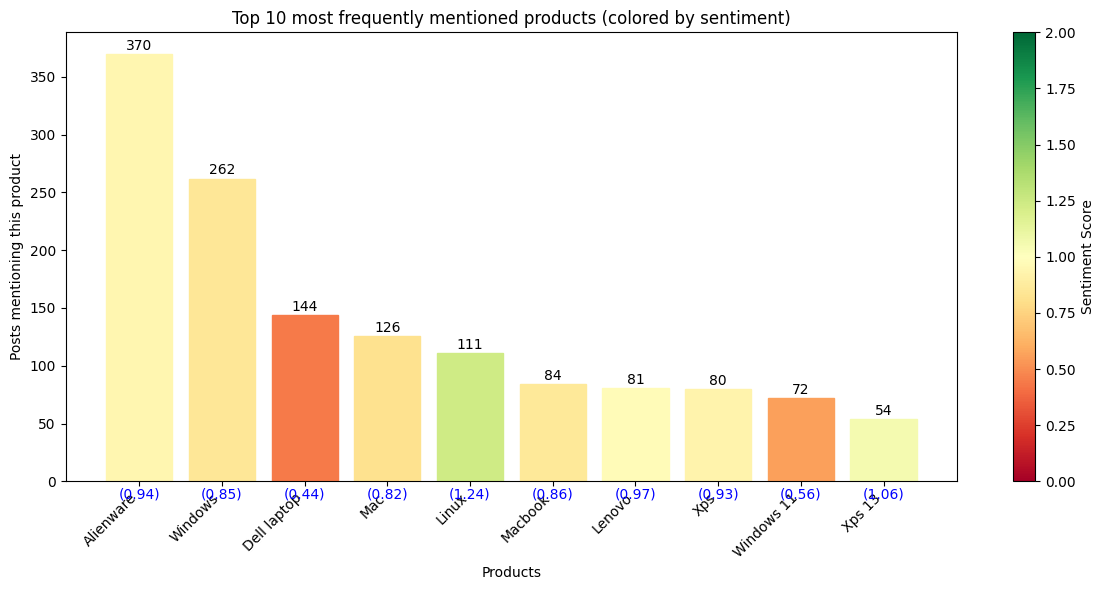

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def barchart_top10_instances_with_sentiment(entity):
    instances = [item[0] for item in top_10_instances2[entity]]
    counts = [item[1] for item in top_10_instances2[entity]]
    sentiments = [item[2] for item in top_10_instances2[entity]]

    cmap = plt.cm.RdYlGn  
    norm = mcolors.Normalize(vmin=0, vmax=2) # color-range from 0 to 2

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(instances)), counts, align="center")

    for i, bar in enumerate(bars):
        if np.isnan(sentiments[i]):
            bar.set_color("black")  
        else:
            bar_color = cmap(norm(sentiments[i]))
            bar.set_color(bar_color)

    for i, v in enumerate(counts):
        ax.text(i, v + 1, str(v), ha='center', va='bottom')

    for i, sentiment in enumerate(sentiments):
        ax.text(i, -5, f"({sentiment:.2f})", ha='center', va='top', color='blue')

    ax.set_xticks(range(len(instances)))
    ax.set_xticklabels(instances, rotation=45, ha='right')
    ax.set_xlabel(f"{entity.capitalize()}s")
    ax.set_ylabel(f"Posts mentioning this {entity}")
    ax.set_title(f"Top 10 most frequently mentioned {entity}s (colored by sentiment)")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Sentiment Score')

    plt.tight_layout()
    plt.show()

barchart_top10_instances_with_sentiment("product")

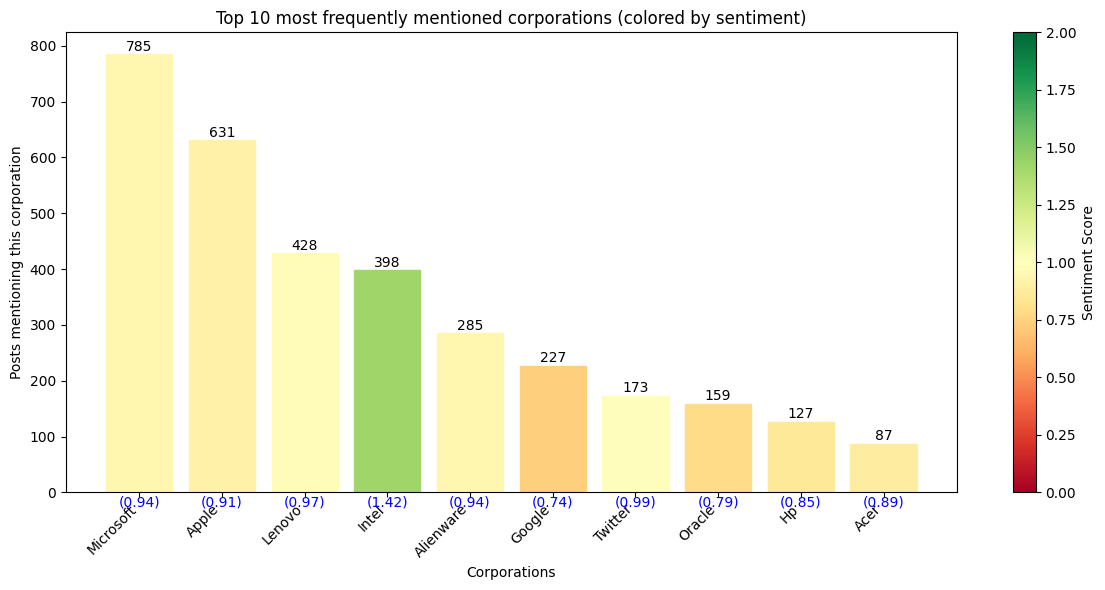

In [30]:
barchart_top10_instances_with_sentiment("corporation")

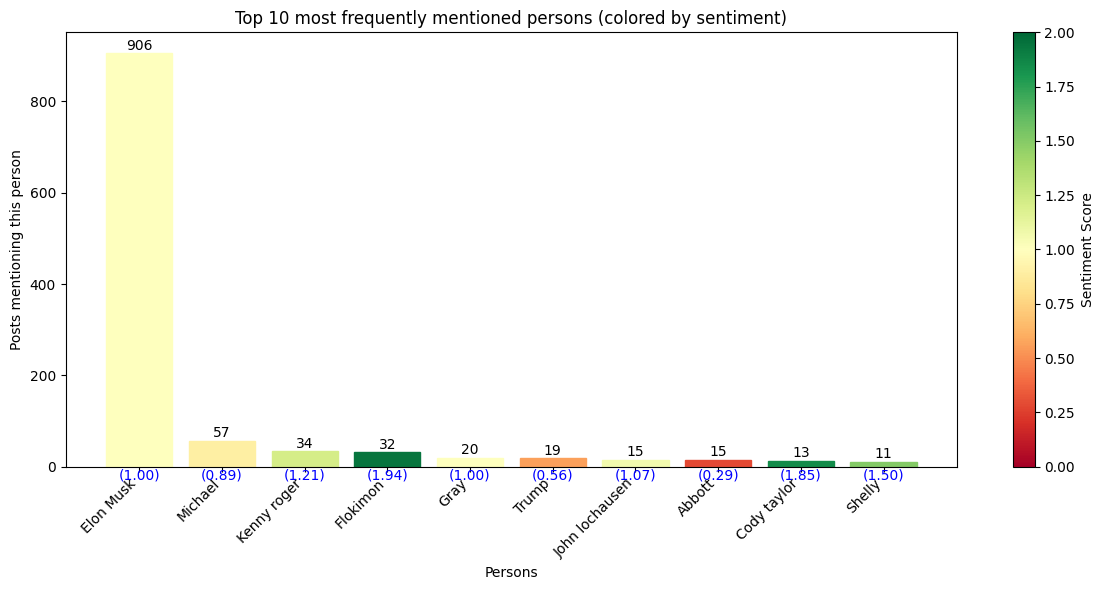

In [31]:
barchart_top10_instances_with_sentiment("person")

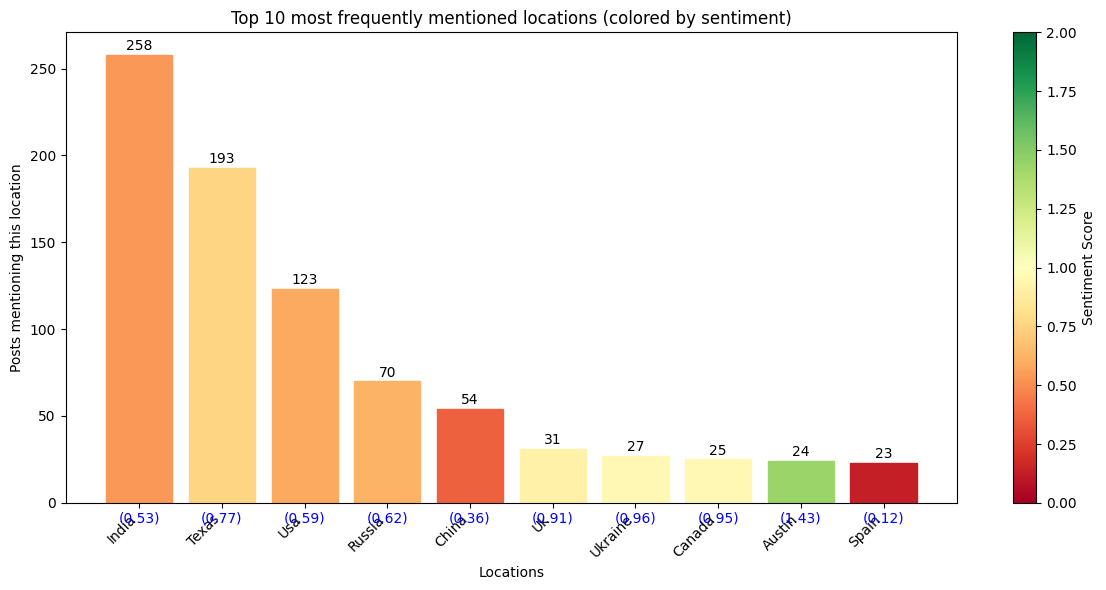

In [32]:
barchart_top10_instances_with_sentiment("location")

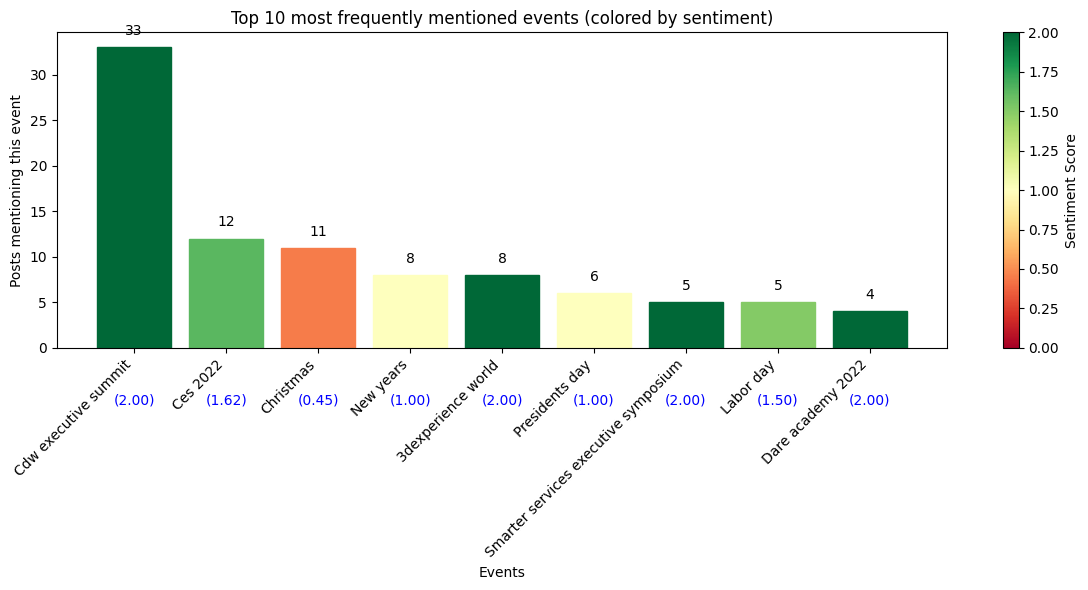

In [33]:
barchart_top10_instances_with_sentiment("event")

conclusions:
- corporations: posts mentioning "intel" are the most positive out of the top 10 instances, with Google and Tesla being mentioned in more negative posts
- products: posts mentioning Dell laptops are mostly negative, Linux is the most positively discussed product of the top 10 most mentioned (average of 1.24)
- persons: Elon Musk is by far the most discussed person in either a neutral or highly diverse fashion, Michael likely refers to Dell-CEO Michael Dell
- location: India most frequently mentioned and associated with negative sentiment, Austin is the most positively discussed location in top 10
- event: most mentioned event is the CDW executive summit, holidays are also in top 10

### time-based plots

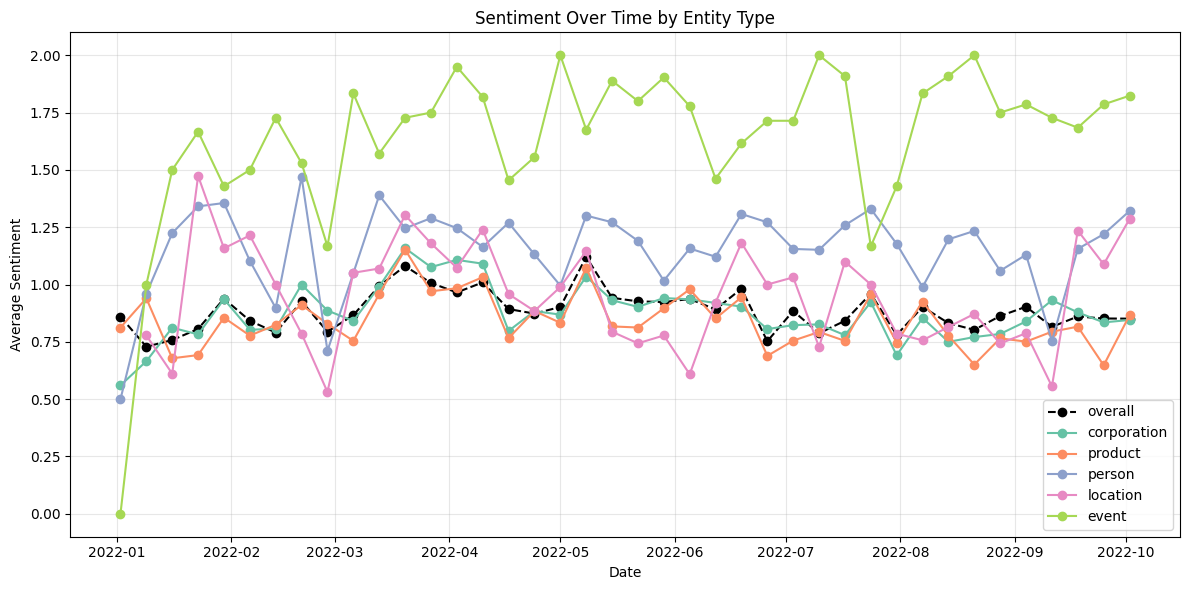

In [34]:
# getting general time based overview
import seaborn as sns

plt.figure(figsize=(12, 6))

# plotting the overall sentiment using the weekly average
weekly_sentiment = df_dell_p.groupby(pd.Grouper(key="Datetime", freq="W"))["bert_pred_sa"].mean().reset_index()
plt.plot(weekly_sentiment["Datetime"], weekly_sentiment["bert_pred_sa"], marker="o", linestyle="dashed", color="black", label="overall")

# plotting the average sentiment for all rows mentioning the entities, adding colors dynamically
colors = sns.color_palette("Set2", n_colors=len(unique_entities))
for i, entity_type in enumerate(unique_entities):
    entity_df = df_dell_p[df_dell_p["entity_types"].apply(lambda x: entity_type in x)]
    weekly_sentiment_filtered = entity_df.groupby(pd.Grouper(key="Datetime", freq="W"))["bert_pred_sa"].mean().reset_index()
    plt.plot(weekly_sentiment_filtered["Datetime"], weekly_sentiment_filtered["bert_pred_sa"], 
             marker="o", linestyle="-", color=colors[i], label=entity_type)

plt.legend()
plt.title("Sentiment Over Time by Entity Type")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

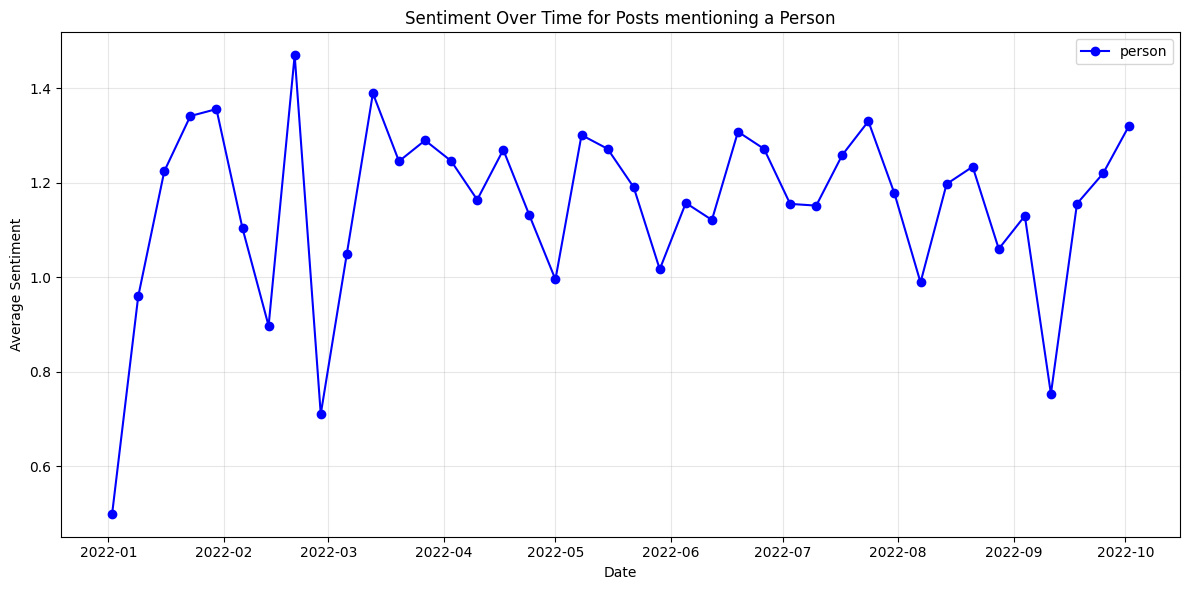

In [35]:
# more specific time-based insights
def plot_sentiment_for_entities_over_time(df, entities):
    plt.figure(figsize=(12, 6))

    if isinstance(entities, str):
        entity_df = df[df["entity_types"].apply(lambda x: entities in x)]

        weekly_sentiment = entity_df.groupby(pd.Grouper(key="Datetime", freq="W"))["bert_pred_sa"].mean().reset_index()
        plt.plot(weekly_sentiment["Datetime"], weekly_sentiment["bert_pred_sa"], 
                 marker="o", linestyle="-", color="blue", label=entities)

        plt.legend()
        plt.title(f"Sentiment Over Time for Posts mentioning a {entities.capitalize()}")
    
    if isinstance(entities, list):
        entity_df = df[df["entity_types"].apply(lambda x: all(ent in x for ent in entities))]

        weekly_sentiment = entity_df.groupby(pd.Grouper(key="Datetime", freq="W"))["bert_pred_sa"].mean().reset_index()
        plt.plot(weekly_sentiment["Datetime"], weekly_sentiment["bert_pred_sa"], 
                 marker="o", linestyle="-", color="blue", label=", ".join([ent for ent in entities]))

        plt.legend()
        plt.title(f"Sentiment Over Time for Posts mentioning {", ".join([ent.capitalize() for ent in entities])}")
        
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_sentiment_for_entities_over_time(df_dell_p, "person")

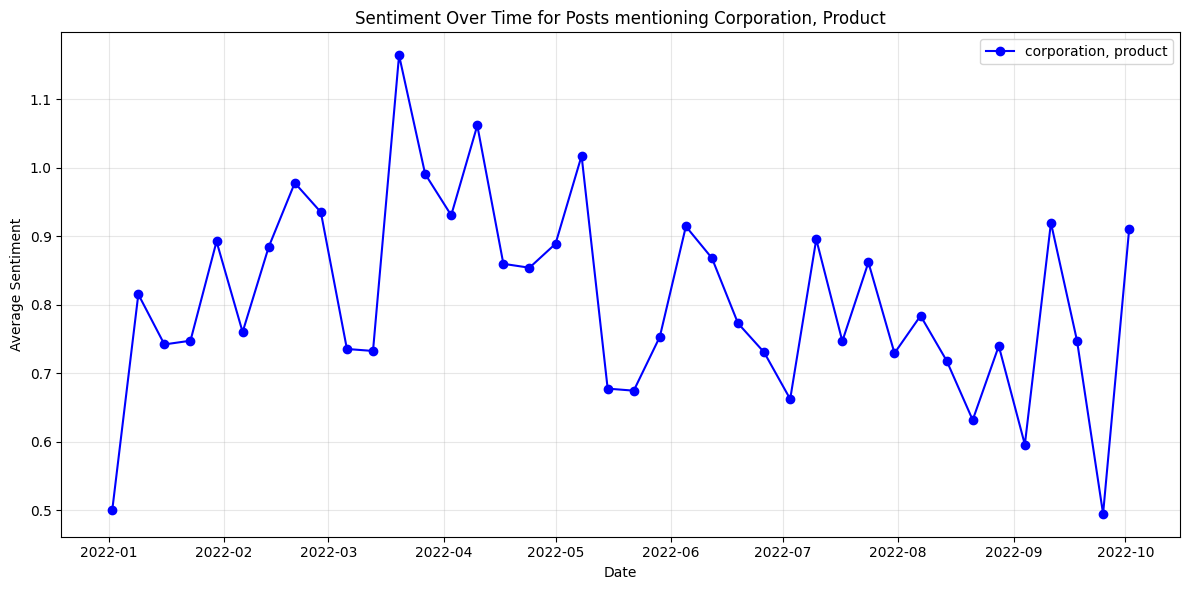

In [36]:
plot_sentiment_for_entities_over_time(df_dell_p, ["corporation", "product"])

conclusions:
- overall sentiment is relatively consistently hovering around 0.9 with the peak being reached in May 2022 (~1.1), lowest overall sentiment in January 2022 (~0.75)
- posts mentioning events are generally the most positive except for a negative start at the beginning of 2022, but relatively small sample size (704 posts detected as mentioning an event)
- persons are discussed with mostly positive sentiment over entire time period (majority of weekly averages > 1)